# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, we build a Convolution Network to classify German Traffic Signs. This is the second porject of the first term in the Udacity Self Driving Car Engineer nanodegree. The objective is to achive at least 93% accuracy on the test sample with a Neural Network we have to implement.
We roughly follow the ideas from the paper http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf.
First we explore the Data, augment it and preprocess it.
We then build the Convolution Network, whose architecture is described further below.
Finally, we train it and test it on the test data, and also on an extra set of images we obtained from the internet, to further evaluate its robustness.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = 'Data/train.p'
validation_file= 'Data/valid.p'
testing_file = 'Data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**



### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Quick overview of the dataset
import numpy as np

n_train = len(X_train)
n_validation = len(X_validation)
n_test = len(X_test)
image_shape = X_train[0].shape
sign_classes, class_indices, class_counts = np.unique(y_train, return_index = True, return_counts = True)
sign_classes_v, class_indices_v, class_counts_v = np.unique(y_validation, return_index = True, return_counts = True)
sign_classes_t, class_indices_t, class_counts_t = np.unique(y_test, return_index = True, return_counts = True)
n_classes = len(class_counts)

print("Number of training examples =", n_train)
print("Number of validating examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validating examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

Here we visualize our data, allowing us to become familiar with its structure, as well as with potential issues that might arise when developing and training our network.
We first take a look at a few of the types of traffic signs in our data, and we then compute and plot the frequency of each label in our train, validation and test data sets.

Label 19: Dangerous curve to the left                         180 samples


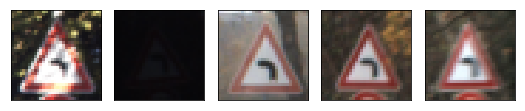

Label 22: Bumpy road                                          330 samples


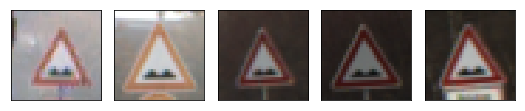

In [3]:
import random
from pandas.io.parsers import read_csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
signnames = read_csv("signnames.csv").values[:, 1]

col_width = max(len(name) for name in signnames)
labels_fraction = 0.15

for label, label_index, label_count in zip(sign_classes, class_indices, class_counts):
    if random.uniform(0,1)<labels_fraction:
        print("Label %i: %-*s  %s samples" % (label, col_width, signnames[label], str(label_count)))
        fig = plt.figure(figsize = (7, 5))
        fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.15)
        random_indices = random.sample(range(label_index, label_index + label_count), 5)
        for i in range(5):
            axis = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
            axis.imshow(X_train[random_indices[i]])
        plt.show()
        



## Frequencies
We now want to plot the frequncies of each label in each of our data sets (trainig, validation and testing).

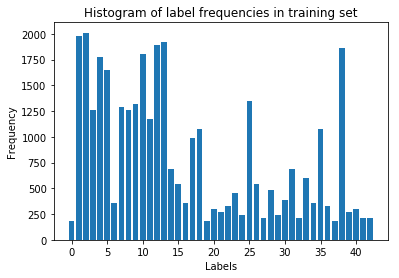

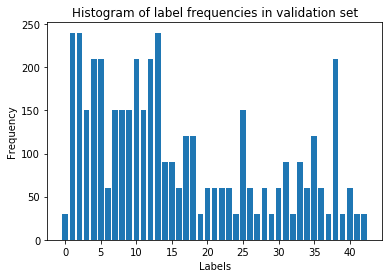

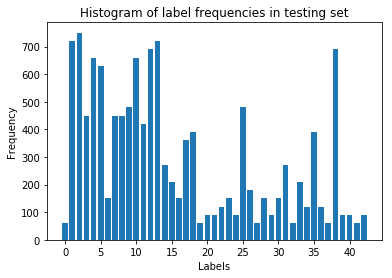

In [4]:
label_dict = {
    "training": class_counts,
    "validation": class_counts_v,
    "testing": class_counts_t
}

for stage, y in label_dict.items():
    plt.bar( np.arange( 43 ), y, align='center' )
    plt.title("Histogram of label frequencies in {} set".format(stage))
    plt.xlabel("Labels")
    plt.ylabel("Frequency")
    plt.xticks(range(0, 43, 5))
    plt.show()

### Augmenting the dataset

For some of our labels we have very few examples in our data. A simple way to obtain more examples, while at the same time increasing the robustness of our model, is to perturbate the images we already have. 
Whether the sign is displaced a couple pixels, slightly rotated or a bit blurred should (ideally) not have an effect on the way we would classify it. Therefore, we can introduce these transformations of our images to increase the amount of data we will feed to our classifier.

Usually it would be a good idea to also introduce some redundancy for those labels that are underrepresented in our training data, but since the distribution of the labels looks fairly similar across all three data sets, this is a step we will not introduce (implicitly, we are assuming that the frequency of the signs in the real world is similar to the one we see in our data, and therefore that a random sample would look not too different from the data set).

Below we will introduce a few transformations that we will use to augment the data:
* Shifts
* Rotations
* Homography
* Blurs
* Noise

28


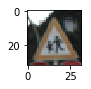

In [5]:
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

In [6]:
import cv2


def apply_shift(img):
    which_axis = random.randrange(2)
    shapex = img.shape[0]
    shapey = img.shape[1]
    
    if which_axis < 1:
        aux0, aux1 = img[0,:], img[1,:]
        img[0,:], img[1,:] = img[shapex-2,:], img[shapex-1,:]
        img[shapex-2,:], img[shapex-1,:] = aux0, aux1
         
    
    else:
        aux0, aux1 = img[:,0], img[:,1]
        img[:,0], img[:,1] = img[:,shapey-2], img[:,shapey-1]
        img[:,shapey-2], img[:,shapey-1] = aux0, aux1
         
    
    return img

def apply_rotation(img):
    M = cv2.getRotationMatrix2D((16,16),np.random.uniform(-20,20),1)
    return cv2.warpAffine(img, M, (32,32))

def apply_homography(img):
    source_points = np.array([[12,16], [16,20], [20,16], [16,12]],np.float32)
    noise = np.random.normal(scale=0.2, size=source_points.shape)
    target_points = source_points + noise
    h, status = cv2.findHomography(source_points, target_points)
    im_out = cv2.warpPerspective(img, h, dsize=(32,32))
    return im_out

def apply_blur(img):
    return cv2.GaussianBlur(img,(3,3),0)

def apply_noise(img):
    noise = np.random.normal(scale=3.0,size=img.shape)
    return np.clip(np.round(img + noise), 0.0, 256.0).astype(np.uint8)

Now that we have defined our transformations, we will runa  quick example of what this transformations look like.

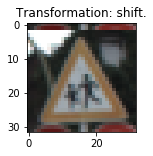

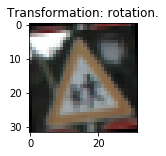

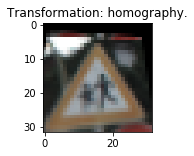

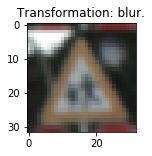

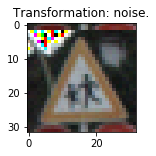

In [7]:
l_transforms = [apply_shift, apply_rotation, apply_homography, apply_blur, apply_noise] 
l_nm = ["shift", "rotation", "homography", "blur", "noise"] 

for tran, nm in zip(l_transforms, l_nm):
    img = tran(X_train[index])
    plt.figure(figsize=(2,2))
    plt.title("Transformation: {}.".format(nm))
    plt.imshow(img)
    



We are now ready to augment the data. Applying these transformations to our training set will increase the amount of training examples by 500%! We expect our model to be more robust, but it will also take longer to train. We will actually run the data augmentation with each batch of our training (and it will already be in grayscale, which explains the shape we are imposing).

In [8]:
from sklearn.utils import shuffle

def build_augmented_dataset(X, Y):
    
    shifts = [np.reshape(apply_shift(x),(32,32,1)) for x in X]  
    rotations = [np.reshape(apply_rotation(x),(32,32,1)) for x in X]
    homographies = [np.reshape(apply_homography(x),(32,32,1)) for x in X]
    blurs = [np.reshape(apply_blur(x),(32,32,1)) for x in X]
    noisy = [np.reshape(apply_noise(x),(32,32,1)) for x in X]    
    to_stack = (X, shifts, rotations, homographies, blurs, noisy)
    augmented_X = np.concatenate(to_stack, axis=0)
    augmented_Y = np.concatenate(len(to_stack)*(Y,),axis=0)
    augmented_X, augmented_Y = shuffle(augmented_X, augmented_Y)
    
    return augmented_X, augmented_Y



----

## Step 2: Design and Test a Model Architecture

It is now time to build and train our classifier. In order to do so we will come up with a network architecture (which will be heavily based on the one proposed by http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). Deciding what the best network architecure might be for a given problem is more art than science (at least until now), so we tested the simpler LeNet network we had from the lessons, but after reading the above paper, we decided to follow the newer approach.
We will also convert our images to grayscale and normalize them. The data augmentation will happen during the training, with each batch of the training data bein augmented in situ, instead of creating very large data files. We will not create a balanced data set. The reason, as we mentioned above, is that all three data sets have similar distributions, and without any other information, it is reasonable to suppose that the frequencies in the data set reflect the frequencies in the German roads. If we had more information, or if we considered that certain mistakes are more costly than others (say missing a STOP sign is more dangerous than missing the 80km/h speed limit), we could try and reflect that in our data set.

### Pre-process the Data Set 

We have three steps to our preprocessing:
* Turning the images into grayscale
* Performing histogram equalization
* Normalizing the data

4


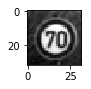

In [9]:
### First we convert to Grayscale which, according to Sermante and LeCun, actually improves the performance.

import math


def grayscale(img):    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)    

X_train = np.array([grayscale(img) for img in X_train])
X_validation = np.array([grayscale(img) for img in X_validation])
X_test = np.array([grayscale(img) for img in X_test])

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(image, cmap='gray')
print(y_train[index])
#print(X_train[index])




4


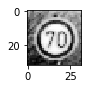

In [10]:
### We then perform histogram equalization, which improves the contrast in the images:
X_train = np.array([cv2.equalizeHist(img) for img in X_train])
X_validation = np.array([cv2.equalizeHist(img) for img in X_validation])
X_test = np.array([cv2.equalizeHist(img) for img in X_test])

X_train = np.array([np.reshape(img,(32,32,1)) for img in X_train])
X_validation = np.array([np.reshape(img,(32,32,1)) for img in X_validation])
X_test = np.array([np.reshape(img,(32,32,1)) for img in X_test])

image = X_train[index].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(image, cmap='gray')
print(y_train[index])
#print(X_train[index])

4


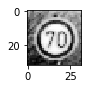

In [11]:
### Finally we normalize our data, image by image.
X_train = np.array([(img / 255.).astype(np.float32) for img in X_train])
X_validation = np.array([(img / 255.).astype(np.float32) for img in X_validation])
X_test = np.array([(img / 255.).astype(np.float32) for img in X_test])

image = X_train[index].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(image, cmap='gray')
print(y_train[index])
#print(X_train[index])

### Model Architecture

In [12]:
# We pick the number of Epochs and the Batch size. We have a small batch size because we will apply data augmentation
# at the batch level, and thus we are using BATCH_SIZE times 6 data points.

import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 64

image_shape = X_train[0].shape
print(image_shape)

(32, 32, 1)


In [13]:
# The architecture of our network resembles that of the Sermanet paper. The main idea
# is that the output of each convolution is later fed to a single fully connected layer
# with the idea that the outputs of different convolutions capture different features

# We are also using selu(x) as activation. This function induces self normalizing to the network.

from tensorflow.contrib.layers import flatten

keep_prob_ = tf.placeholder(tf.float32, name = "keep_prob")
rate_ = tf.placeholder(tf.float32, name = "rate")

def selu(x):
    alpha = 1.67
    scale = 1.05
    return scale*tf.where(x>=0, x, alpha*tf.nn.elu(x))

def LeNet(x):    
    
    mu = 0
    sigma = 0.1
    
    # Layer 1 Convolution
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = selu(conv1)    
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv1 = tf.nn.dropout(conv1,keep_prob_)

    # Layer 2 Convolution
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b    
    conv2 = selu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv2 = tf.nn.dropout(conv2,keep_prob_)
    
    # Layer 3 Convolution
    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 32), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(32))
    conv3 = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b    
    conv3 = selu(conv3)
    conv3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv3 = tf.nn.dropout(conv3,keep_prob_)              
    
    # Repool layers 1 and 2
    
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')      
    
    # Flatten    
    fc0   = tf.concat([flatten(conv3), flatten(conv2), flatten(conv1)],1)
   
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1040, 512), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(512))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = selu(fc1)
    fc1 = tf.nn.dropout(fc1,keep_prob_*0.75)

    # Layer 4 Fully Connected
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(512, 256), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(256))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    fc2 = selu(fc2)
    fc2 = tf.nn.dropout(fc2,keep_prob_)

    # Layer 5 Fully Connected.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(256, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [14]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [15]:
### Train your model here.


logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate_)
training_operation = optimizer.minimize(loss_operation)

In [16]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_: 1.0, rate_:0.001})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [ ]:
"""

save_file = './model.ckpt'
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            batch_x, batch_y = build_augmented_dataset(batch_x, batch_y)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_: 0.85})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        training_accuracy = evaluate(X_train, y_train)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Train Accuracy = {:.3f}".format(training_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

"""

In [17]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    validation_accuracy = evaluate(X_validation, y_validation)
    print("Test Accuracy = {:.3f}".format(validation_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.958


In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            batch_x, batch_y = build_augmented_dataset(batch_x, batch_y)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_: 0.8, rate_:0.0002})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        training_accuracy = evaluate(X_train, y_train)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Train Accuracy = {:.3f}".format(training_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

INFO:tensorflow:Restoring parameters from ./lenet
Training...



In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            batch_x, batch_y = build_augmented_dataset(batch_x, batch_y)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_: 0.75, rate_:0.0001})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        training_accuracy = evaluate(X_train, y_train)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Train Accuracy = {:.3f}".format(training_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")